In [30]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split

from dataset import DogDataset
from model import UNet
import evaluate_model

# Hyper parameters

In [2]:
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 3e-4
NUM_OF_CLASSES = 1

# Loading data set

In [3]:
dog_dataset_dir = "Dataset"
transform_for_unet = Compose([
    Resize((512,512)),
    ToTensor(),
])

dog_dataset = DogDataset(dataset_dir=dog_dataset_dir, transform=transform_for_unet)
print("Length of dataset: ", len(dog_dataset))




Length of dataset:  180


# Dividing data into train and test sets

In [4]:
train_data_length = math.ceil(0.7 * len(dog_dataset))
test_data_length = len(dog_dataset) - train_data_length

train_data, test_data = random_split(dog_dataset, [train_data_length, test_data_length])

print("Test dataset length: ", len(test_data))
print("Train dataset length: ", len(train_data))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Test dataset length:  54
Train dataset length:  126


# Visualising data

Data batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8, 1, 512, 512])
torch.Size([512, 512])


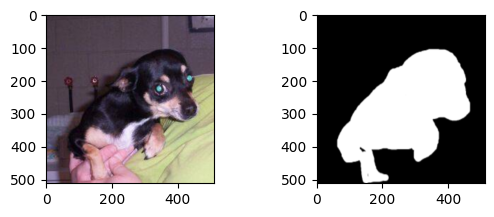

In [5]:
data_imges, label_imges = next(iter(train_dataloader))
print(f"Data batch shape: {data_imges.size()}")
print(f"Labels batch shape: {label_imges.size()}")

data_img = data_imges[0].permute(1, 2, 0).numpy()
label_img = label_imges[0].squeeze()

print(label_img.shape)

figure = plt.figure()
ax1 = figure.add_subplot(2,2,1)
ax1.imshow(data_img)
ax2 = figure.add_subplot(2,2,2)
ax2.imshow(label_img, cmap="gray")
plt.show()

# Model creation

### Checking if the model looks correct

In [6]:
input_image = torch.rand((1, 3, 512, 512))
model_test = UNet(num_classes=NUM_OF_CLASSES)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_test.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_test.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
outputs = model_test(input_image)
print(outputs.shape)

31,031,745 total parameters.
31,031,745 training parameters.
torch.Size([1, 1, 512, 512])


### Initializing a model

In [7]:
model = UNet(num_classes=NUM_OF_CLASSES)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training (without validation)

In [8]:
for epoch in range(EPOCHS):
    model.train()
    train_running_loss = 0
    print(f"Current EPOCH {epoch + 1}")

    for idx, data in enumerate(train_dataloader):
        img = data[0].float().to(device)
        mask = data[1].float().to(device)

        predicted_mask = model(img)
        optimizer.zero_grad()

        loss = loss_fn(predicted_mask, mask)
        single_loop_loss = loss.item()
        train_running_loss += single_loop_loss
        

        loss.backward()
        optimizer.step()
        print(f"    Batch {idx + 1} running loss: {single_loop_loss}")

    train_loss = train_running_loss / (idx + 1)

    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")

Current EPOCH 1
    Batch 1 running loss: 0.6926157474517822
    Batch 2 running loss: 0.6788726449012756
    Batch 3 running loss: 0.6864544153213501
    Batch 4 running loss: 0.6863349676132202
    Batch 5 running loss: 0.6804394125938416
    Batch 6 running loss: 0.6776155233383179
    Batch 7 running loss: 0.6725958585739136
    Batch 8 running loss: 0.6584023237228394
    Batch 9 running loss: 0.6705163717269897
    Batch 10 running loss: 0.680945098400116
    Batch 11 running loss: 0.6972811222076416
    Batch 12 running loss: 0.682722806930542
    Batch 13 running loss: 0.6689215302467346
    Batch 14 running loss: 0.6774725914001465
    Batch 15 running loss: 0.7060853242874146
    Batch 16 running loss: 0.6446994543075562
Train Loss EPOCH 1: 0.6789
Current EPOCH 2
    Batch 1 running loss: 0.6599244475364685
    Batch 2 running loss: 0.6462681293487549
    Batch 3 running loss: 0.6770989894866943
    Batch 4 running loss: 0.685162365436554
    Batch 5 running loss: 0.672097623

# Inteference of a model

tensor([[[[-0.9204, -1.3988, -1.4996,  ..., -1.6218, -1.5031, -0.9925],
          [-1.1766, -1.8016, -1.9029,  ..., -2.0888, -2.0142, -1.3748],
          [-1.0756, -1.6293, -1.6527,  ..., -1.9038, -1.9231, -1.3531],
          ...,
          [-0.5123, -0.7063, -0.6574,  ..., -1.0157, -0.9957, -0.7209],
          [-0.4794, -0.6797, -0.6610,  ..., -0.9168, -0.8880, -0.6411],
          [-0.3319, -0.4594, -0.4606,  ..., -0.5843, -0.5710, -0.4217]]]],
       device='cuda:0')
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


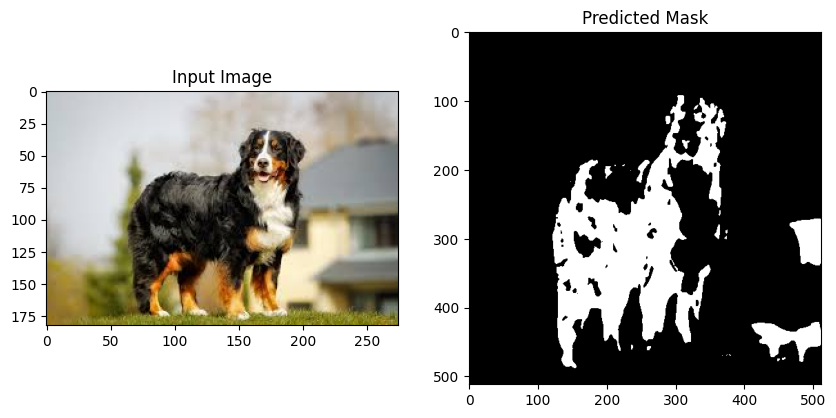

In [ ]:
# Set the model in evaluation mode for inference
model.eval()

# Define a transform for the test image
inference_transform = Compose([Resize((512, 512)), ToTensor()])

# Load and preprocess the test image
test_image_path = "inference_img3.jfif"
test_image = Image.open(test_image_path).convert("RGB")
input_tensor = inference_transform(test_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run inference
with torch.no_grad():  # No gradient computation needed
    predicted_output = model(input_tensor)

print(predicted_output)
# Apply sigmoid and threshold to create a binary mask
binary_mask = torch.sigmoid(predicted_output).squeeze().cpu().numpy()  # Apply sigmoid to get probabilities
binary_mask = (binary_mask > 0.5).astype(int)  # Threshold at 0.5 to create a binary mask

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Input Image")
plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap="gray")
plt.title("Predicted Mask")
plt.show()


In [ ]:
evaluate_model(model, test_dataloader, device)